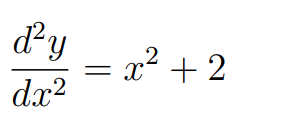

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def exact_sol(x):
  return (x**4 / 12) + x**2 + 2*x + 1

In [4]:
x = np.linspace(0, 1, 100)
y = exact_sol(x)

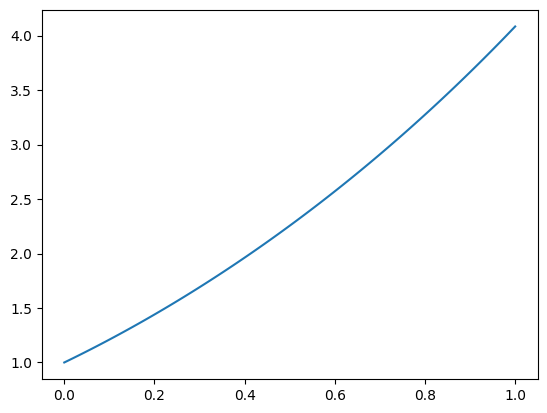

In [5]:
plt.plot(x, y)

In [6]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.6 MB/s eta 0:00:00


In [7]:
import deepxde as dde

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [8]:
geom = dde.geometry.Interval(0, 1)

In [9]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - x**2 - 2

In [10]:
def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def func(x):
  return x**4 / 12 + x**2 + 2*x + 1

def d_func(x):
  return x**3 / 3 + 2 * x  + 2

def dy_x(x, y, X):
  dy_x = dde.grad.jacobian(y, x)
  return dy_x

bc_l = dde.icbc.DirichletBC(geom, func, boundary_l)

boundary_pts = geom.random_boundary_points(2)
r_boundary_pts = boundary_pts[dde.utils.isclose(boundary_pts, 0)].reshape(-1, 1)
bc_r = dde.icbc.PointSetOperatorBC(r_boundary_pts, d_func(r_boundary_pts), dy_x)

In [11]:
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=exact_sol, num_test=100)

In [12]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [13]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.339869 s

'compile' took 1.261853 s



In [14]:
losshistory, train_state = model.train(iterations=10000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.77e+00, 1.00e+00, 2.75e+00]    [5.80e+00, 1.00e+00, 2.75e+00]    [9.25e-01]    
1000      [1.71e-04, 2.58e-08, 2.02e-08]    [1.10e-04, 2.58e-08, 2.02e-08]    [5.65e-05]    
2000      [2.75e-05, 9.78e-07, 3.07e-05]    [2.30e-05, 9.78e-07, 3.07e-05]    [8.52e-04]    
3000      [1.97e-05, 3.63e-08, 1.60e-05]    [1.64e-05, 3.63e-08, 1.60e-05]    [7.51e-04]    
4000      [1.70e-05, 7.30e-07, 3.36e-06]    [1.32e-05, 7.30e-07, 3.36e-06]    [7.48e-04]    
5000      [1.50e-05, 2.28e-08, 3.52e-09]    [1.21e-05, 2.28e-08, 3.52e-09]    [9.21e-05]    
6000      [1.37e-05, 1.44e-06, 5.72e-06]    [1.08e-05, 1.44e-06, 5.72e-06]    [1.01e-03]    
7000      [1.70e-05, 7.38e-05, 3.63e-04]    [1.23e-05, 7.38e-05, 3.63e-04]    [7.42e-03]    
8000      [4.22e-05, 1.49e-03, 1.47e-03]    [2.57e-05, 1.49e-03, 1.47e-03]    [9.03e-03]    
9000      [1.00e-05, 4.12e-08, 1.76e-07]    [8.18e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


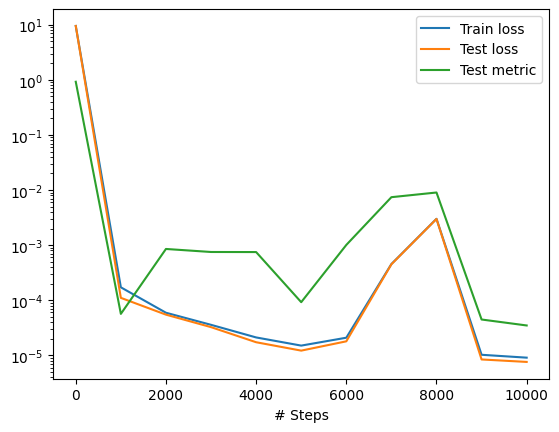

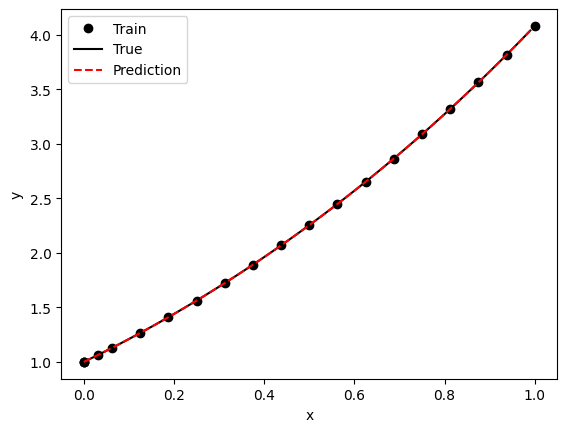

In [15]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [16]:
x = np.vstack(np.ravel(x))
np.max(np.abs(exact_sol(x) - model.predict(x)))

0.00017038981119821273